In [1]:
import plumed
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import MDAnalysis as md
from MDAnalysis.analysis import distances
import pandas as pd
import itertools
import random
from deeptime.decomposition import TICA
from deeptime.covariance import KoopmanWeightingEstimator
from deeptime.clustering import MiniBatchKMeans
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import MaximumLikelihoodMSM
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import implied_timescales
import networkx as nx
from copy import deepcopy
from numpy.random import multinomial
import subprocess
import os
import math
import string
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings('ignore')
###############################USER DEFINE REGION##################################

### Hyperparameters
colvar = 'CV/COLVAR'
topol = 'traj_and_dat/input.pdb'
seed_ref = 'traj_and_dat/seed_ref.pdb'
sim_idx = 5
n_sim = 16
# TICA parameters (for adaptive sampling)
tica_lagtime = 20
dim = None
var_cutoff = 0.95
koopman = True
convergence_check = True
num_cvs = 2

### Analysis functions
def read_features(colvar,sim_idx,n_sim):
    # traj is the time-series COLVAR in pandas.DataFrame format
    traj_idx = []
    for i in range(sim_idx*n_sim):
        traj_idx.append(i)
    
    no_traj = len(traj_idx)
    traj = [0]*no_traj
    
    for i in traj_idx:
        traj[i] = plumed.read_as_pandas(colvar+'_{i}'.format(i=i))
        traj[i] = traj[i].drop(columns=['time'])
        columns = list(traj[i].columns.values)
        # Remove all dihedral angles, only keep sin/cos dihedrals 
        for column in columns:
            if column[:3] == 'phi' or column[:3] == 'psi' or column[:3] == 'chi' or column[:5] == 'omega':
                traj[i] = traj[i].drop(columns=[column])
            
    # data is the time-series COLVAR in numpy.ndarrays format
    data = [0]*len(traj)
    for i in range(len(traj)):
        numpy_data = traj[i].to_numpy(dtype='float32')
        data[i] = numpy_data
            
    return traj,data

def data_supplement(sim_idx,data,lagtime):
    round_seed_idx = []

    for i in range(1,sim_idx):
        round_seed_idx_i = np.loadtxt('round{i}_seed.txt'.format(i=i),dtype=int)
        round_seed_idx.append(round_seed_idx_i)

    round_seed_idx = np.concatenate(round_seed_idx)

    data_supp = []

    for i,round_seed_idx_i in enumerate(round_seed_idx):
    
        sim_i = round_seed_idx_i[0]
        frame = round_seed_idx_i[1]
    
        if frame == 0:
            continue
        elif lagtime > frame:
            start_frame = 0
        else:
            start_frame = frame - lagtime + 1
    
        end_frame = lagtime
    
        data_supp_pre = data[sim_i][start_frame:frame,:]
        data_supp_post = data[i][:end_frame,:]
        data_supp_i = np.concatenate([data_supp_pre,data_supp_post])
    
        data_supp.append(data_supp_i)
    
    return data_supp
    
def run_TICA(data,data_supp,lagtime,dim=None,var_cutoff=None,koopman=True):
    data_syn = data + data_supp
    tica = TICA(lagtime=lagtime,dim=dim,var_cutoff=var_cutoff)
    if koopman == True:
        koopman_estimator = KoopmanWeightingEstimator(lagtime=lagtime)
        reweighting_model = koopman_estimator.fit(data_syn).fetch_model()
        tica = tica.fit(data_syn, weights=reweighting_model).fetch_model()
    else:
        tica = tica.fit(data_syn).fetch_model()
    # tica is the data-fitted model, which contains eigenvalues and eigenvectors
    # tica_output is the tranformed time-series data in TICA space in shape(traj_idx,no_frames,dim)
    # tica_output_concat is tica_output in shape(traj_idx*no_frames,dim)
    tica_output = tica.transform(data)
    tica_output_concat = np.concatenate(tica_output)

    tica_output_supp = []
    for data_supp_i in data_supp:
        tica_output_supp_i = tica.transform(data_supp_i)
        tica_output_supp.append(tica_output_supp_i)
        
    return tica,tica_output,tica_output_concat,tica_output_supp

In [2]:
traj,data = read_features(colvar,sim_idx,n_sim)
if sim_idx != 1:
    data_supp = data_supplement(sim_idx,data,tica_lagtime)

In [3]:
round_seed_all = []
for i in range(1,sim_idx+1):
    round_seed_i = np.loadtxt('round{i}_seed.txt'.format(i=i),dtype=int)
    round_seed_all.append(round_seed_i)

In [4]:
data[0].shape,len(data)

((41, 45), 80)

In [5]:
# Retrieve all the past tica models if convergence check is required
tica_cv_models = []
if sim_idx != 0 and convergence_check == True:
    
    traj,data = read_features(colvar,sim_idx,n_sim)   # To do: This is repetitive
    if sim_idx != 1:
        data_supp = data_supplement(sim_idx,data,tica_lagtime)
    
    for sim_i in range(1,sim_idx+1):
        data_sim_i = data[:(sim_i*n_sim)]
        if sim_i == 1:
            data_supp_i = []
        else:
            data_supp_i = data_supplement(sim_i,data_sim_i,tica_lagtime)
        data_syn_i = data_sim_i + data_supp_i
        tica_cv_model_i = run_TICA(data_sim_i,data_syn_i,tica_lagtime,num_cvs,None,koopman)[0]
        tica_cv_models.append(tica_cv_model_i)

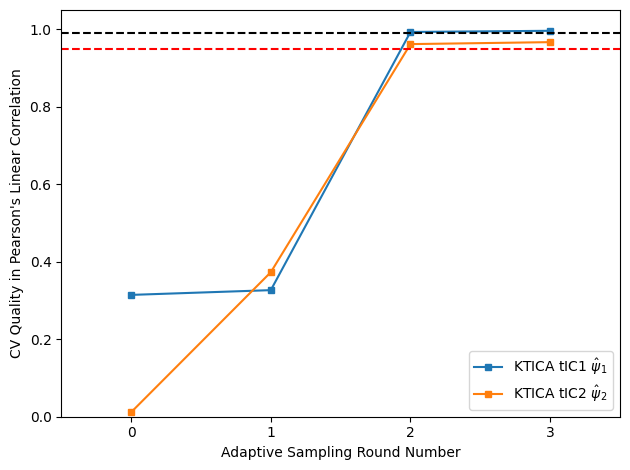

In [6]:
# Review correlations
correlations = np.loadtxt('opes/correlations_round4.txt')
x_ticks = np.linspace(0,3,4,dtype=int)
plt.plot(x_ticks,correlations[:,0],marker='s',ms=5,label=r'KTICA tIC1 $\hat \psi_1$')
plt.plot(x_ticks,correlations[:,1],marker='s',ms=5,label=r'KTICA tIC2 $\hat \psi_2$')
plt.xticks(x_ticks)
plt.xlim(-0.5,3.5)
plt.ylim(0,1.05)
plt.hlines(0.99,-0.5,3.5,colors='black',linestyle='dashed')
plt.hlines(0.95,-0.5,3.5,colors='red',linestyle='dashed')
plt.xlabel('Adaptive Sampling Round Number')
plt.ylabel('CV Quality in Pearson\'s Linear Correlation')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('figures/CV_quality.png',dpi=600,bbox_inches='tight')
plt.show()

In [7]:
# final ktica
tica,tica_output,tica_output_concat,tica_output_supp = run_TICA(data,data_supp,tica_lagtime,dim,var_cutoff,koopman)

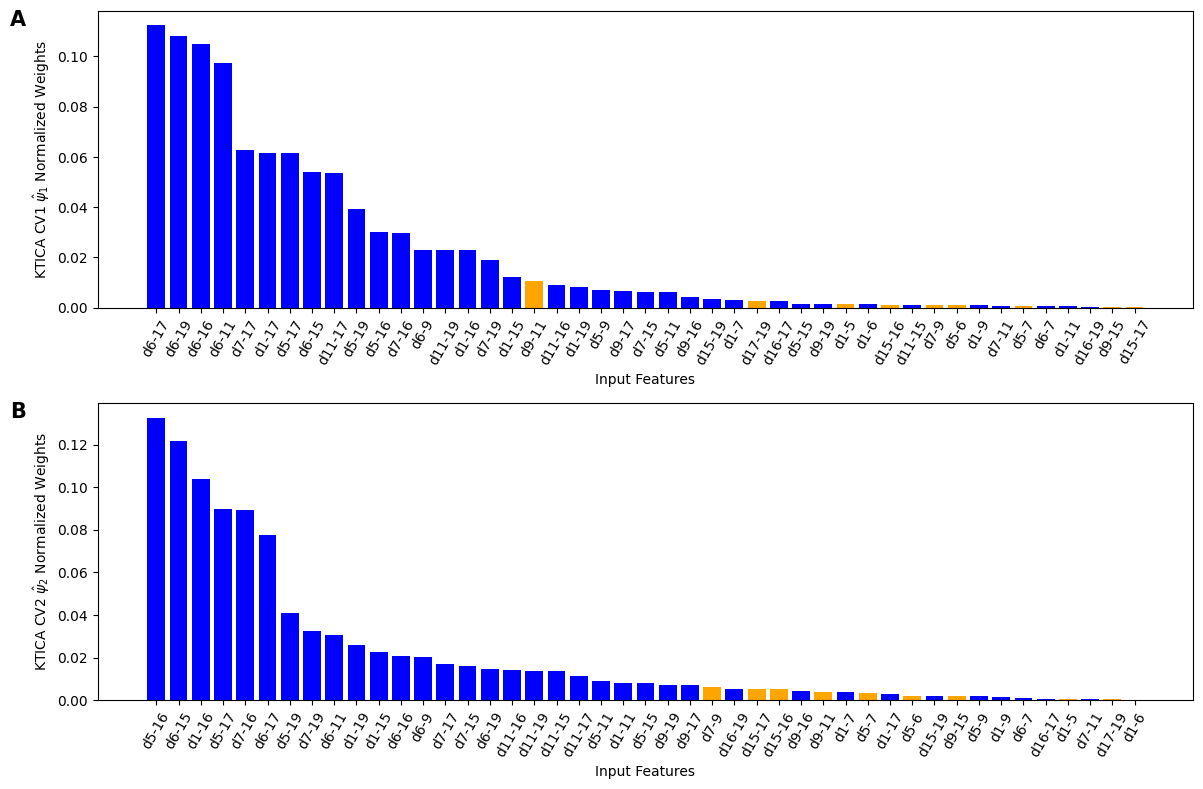

In [8]:
### Descriptor weight analysis

# Retrieve our feature selection
u = md.Universe('traj_and_dat/input.pdb')
heavy_atom = u.select_atoms('name CA or name CB or name O or name N or name CH3 or name C')
ids = list(heavy_atom.ids)
atom_pairs = list(itertools.combinations(ids, 2))

# Retrieve feature labels
columns = list(traj[0].columns.values)

# Plot weight analysis
index_x = -0.08
index_y = 0.95

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(12,8))

adjacent = ['d1-5','d5-6','d5-7','d7-9','d9-11','d9-15','d15-16','d15-17','d17-19']

i = 0

# Consider our input features are not normalized, interpreting the coefficients directly would be misleading,
# as those bond vibrations with a small scale will be assigned to a larger weight,
# while those feature that are really important can be missed due to their larger scale.
weights = np.abs(tica.singular_vectors_left.T[i])*np.concatenate(np.array(data)).std(axis=0)

x_labels = []
for j in np.argsort(weights)[::-1]:
    pair_idx = int(columns[j][4:])-1
    atom1,atom2 = atom_pairs[pair_idx]
    x_labels.append('d{atom1}-{atom2}'.format(atom1=atom1,atom2=atom2))

x = np.linspace(1,len(tica.singular_vectors_left.T[i]),len(tica.singular_vectors_left.T[i]))

weights_sort = weights[np.argsort(weights)][::-1]
normalized_weights = weights_sort/weights_sort.sum()

for k,normalized_weights_k in enumerate(normalized_weights):
    if x_labels[k] in adjacent:
        ax[i].bar(x[k],normalized_weights[k],align='center',color='orange')
    else:
        ax[i].bar(x[k],normalized_weights[k],align='center',color='blue')
        
ax[i].set_xticks(x,x_labels,rotation=60)
ax[i].set_xlabel('Input Features')
ax[i].set_ylabel('KTICA CV1 $\hat \psi_1$ Normalized Weights')

i = 1

# Consider our input features are not normalized, interpreting the coefficients directly would be misleading,
# as those bond vibrations with a small scale will be assigned to a larger weight,
# while those feature that are really important can be missed due to their larger scale.
weights = np.abs(tica.singular_vectors_left.T[i])*np.concatenate(np.array(data)).std(axis=0)

x_labels = []
for j in np.argsort(weights)[::-1]:
    pair_idx = int(columns[j][4:])-1
    atom1,atom2 = atom_pairs[pair_idx]
    x_labels.append('d{atom1}-{atom2}'.format(atom1=atom1,atom2=atom2))

x = np.linspace(1,len(tica.singular_vectors_left.T[i]),len(tica.singular_vectors_left.T[i]))

weights_sort = weights[np.argsort(weights)][::-1]
normalized_weights = weights_sort/weights_sort.sum()

for k,normalized_weights_k in enumerate(normalized_weights):
    if x_labels[k] in adjacent:
        ax[i].bar(x[k],normalized_weights[k],align='center',color='orange')
    else:
        ax[i].bar(x[k],normalized_weights[k],align='center',color='blue')
        
ax[i].set_xticks(x,x_labels,rotation=60)
ax[i].set_xlabel('Input Features')
ax[i].set_ylabel('KTICA CV2 $\hat \psi_2$ Normalized Weights')

ax[0].text(index_x, index_y, string.ascii_uppercase[0],transform=ax[0].transAxes, size=15, weight='bold')
ax[1].text(index_x, index_y, string.ascii_uppercase[1],transform=ax[1].transAxes, size=15, weight='bold')

plt.tight_layout()
plt.savefig('figures/tic_weights.png',dpi=600,bbox_inches='tight')
plt.show()

In [9]:
# TICA phi_1 projection on ref space at round 0,1,6
tica_round_all = []
for i in range(sim_idx-1):
    tica_round_i = np.concatenate(tica_cv_models[i].transform(data))
    tica_round_all.append(tica_round_i)
# Ref data
ref_df = [0] * n_sim * sim_idx
for i in range(len(ref_df)):
    ref_df[i] = plumed.read_as_pandas('CV/COLVAR_ref_{i}'.format(i=i))
ref_data = pd.concat(ref_df)

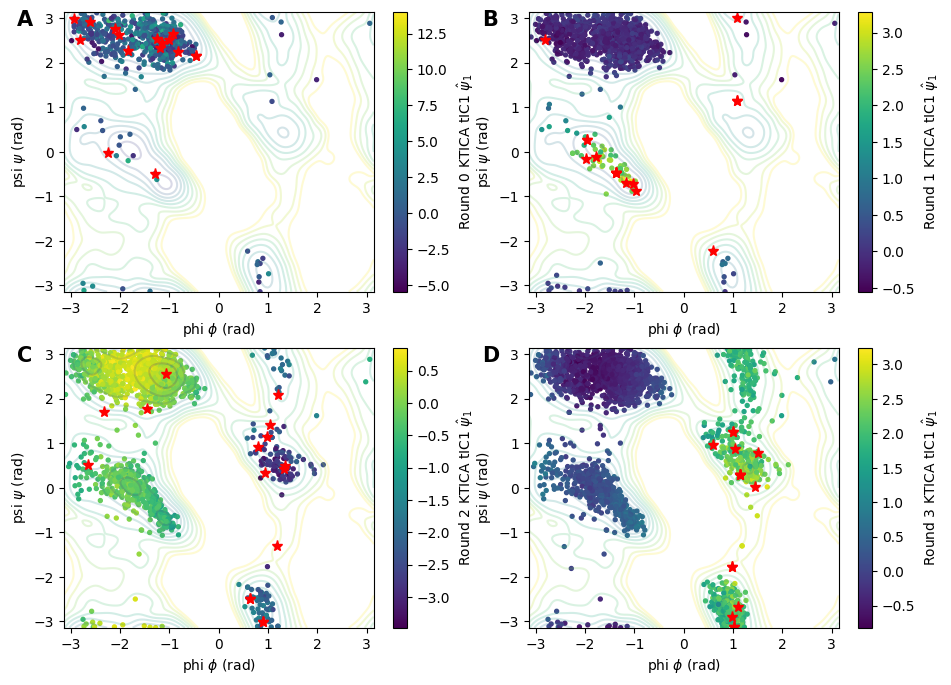

In [10]:
# Adaptive sampling seed selection
index_x = -0.15
index_y = 0.95

fig,ax = plt.subplots(nrows=2,ncols=2,sharex=False,sharey=False,figsize=(11,8))

# We want to include FES as contour plots in the background

vmax = 25

levels = np.linspace(0,vmax,11)
cv1 = 'phi'
cv2 = 'psi'
fes_2d = plumed.read_as_pandas('opes/COLVAR/hist-fes1/fes2d-{cv1}-{cv2}.dat'.format(cv1=cv1,cv2=cv2))
nbins = int(np.sqrt(len(fes_2d.iloc[:,2])))
x = np.linspace(fes_2d[cv1].min(), fes_2d[cv1].max(), nbins)
y = np.linspace(fes_2d[cv2].min(), fes_2d[cv2].max(), nbins)
X, Y = np.meshgrid(x, y)
Z = fes_2d.iloc[:,2].to_numpy().reshape(nbins,nbins).T

ax[0,0].contour(X, Y, Z,vmax=vmax,color='black',levels=levels,alpha=0.2)
ax[0,1].contour(X, Y, Z,vmax=vmax,color='black',levels=levels,alpha=0.2)
ax[1,0].contour(X, Y, Z,vmax=vmax,color='black',levels=levels,alpha=0.2)
ax[1,1].contour(X, Y, Z,vmax=vmax,color='black',levels=levels,alpha=0.2)

# Plot data points with tica values as color
# Plot seeding points

traj_length = 41

idx = 1
sc1 = ax[0,0].scatter(ref_data['phi'][:(n_sim*traj_length*idx)],ref_data['psi'][:(n_sim*traj_length*idx)],c=tica_round_all[idx-1][:(n_sim*traj_length*idx),0],s=8)
for i,j in round_seed_all[idx-1]:
    ax[0,0].plot(ref_df[i]['phi'][j],ref_df[i]['psi'][j],'*',ms=8,color='red')
plt.colorbar(sc1,ax=ax[0,0],label=r'Round 0 KTICA tIC1 $\hat \psi_1$')
    
idx = 2
sc2 = ax[0,1].scatter(ref_data['phi'][:(n_sim*traj_length*idx)],ref_data['psi'][:(n_sim*traj_length*idx)],c=tica_round_all[idx-1][:(n_sim*traj_length*idx),0],s=8)
for i,j in round_seed_all[idx-1]:
    ax[0,1].plot(ref_df[i]['phi'][j],ref_df[i]['psi'][j],'*',ms=8,color='red')
plt.colorbar(sc2,ax=ax[0,1],label=r'Round 1 KTICA tIC1 $\hat \psi_1$')

idx = 3
sc3 = ax[1,0].scatter(ref_data['phi'][:(n_sim*traj_length*idx)],ref_data['psi'][:(n_sim*traj_length*idx)],c=tica_round_all[idx-1][:(n_sim*traj_length*idx),0],s=8)
for i,j in round_seed_all[idx-1]:
    ax[1,0].plot(ref_df[i]['phi'][j],ref_df[i]['psi'][j],'*',ms=8,color='red')
plt.colorbar(sc3,ax=ax[1,0],label=r'Round 2 KTICA tIC1 $\hat \psi_1$')

idx = 4
sc4 = ax[1,1].scatter(ref_data['phi'][:(n_sim*traj_length*idx)],ref_data['psi'][:(n_sim*traj_length*idx)],c=tica_round_all[idx-1][:(n_sim*traj_length*idx),0],s=8)
for i,j in round_seed_all[idx-1]:
    ax[1,1].plot(ref_df[i]['phi'][j],ref_df[i]['psi'][j],'*',ms=8,color='red')
plt.colorbar(sc4,ax=ax[1,1],label=r'Round 3 KTICA tIC1 $\hat \psi_1$')

ax[0,0].text(index_x, index_y, string.ascii_uppercase[0],transform=ax[0,0].transAxes, size=15, weight='bold')
ax[0,0].set_xlabel('phi $\phi$ (rad)')
ax[0,0].set_ylabel('psi $\psi$ (rad)')
ax[0,1].text(index_x, index_y, string.ascii_uppercase[1],transform=ax[0,1].transAxes, size=15, weight='bold')
ax[0,1].set_xlabel('phi $\phi$ (rad)')
ax[0,1].set_ylabel('psi $\psi$ (rad)')
ax[1,0].text(index_x, index_y, string.ascii_uppercase[2],transform=ax[1,0].transAxes, size=15, weight='bold')
ax[1,0].set_xlabel('phi $\phi$ (rad)')
ax[1,0].set_ylabel('psi $\psi$ (rad)')
ax[1,1].text(index_x, index_y, string.ascii_uppercase[3],transform=ax[1,1].transAxes, size=15, weight='bold')
ax[1,1].set_xlabel('phi $\phi$ (rad)')
ax[1,1].set_ylabel('psi $\psi$ (rad)')

#plt.tight_layout()
plt.setp(ax,xlim=(-3.142,3.142),ylim=(-3.142,3.142))

plt.savefig('figures/adaptive_seeding_tIC1.png',dpi=600,bbox_inches='tight')
plt.show()

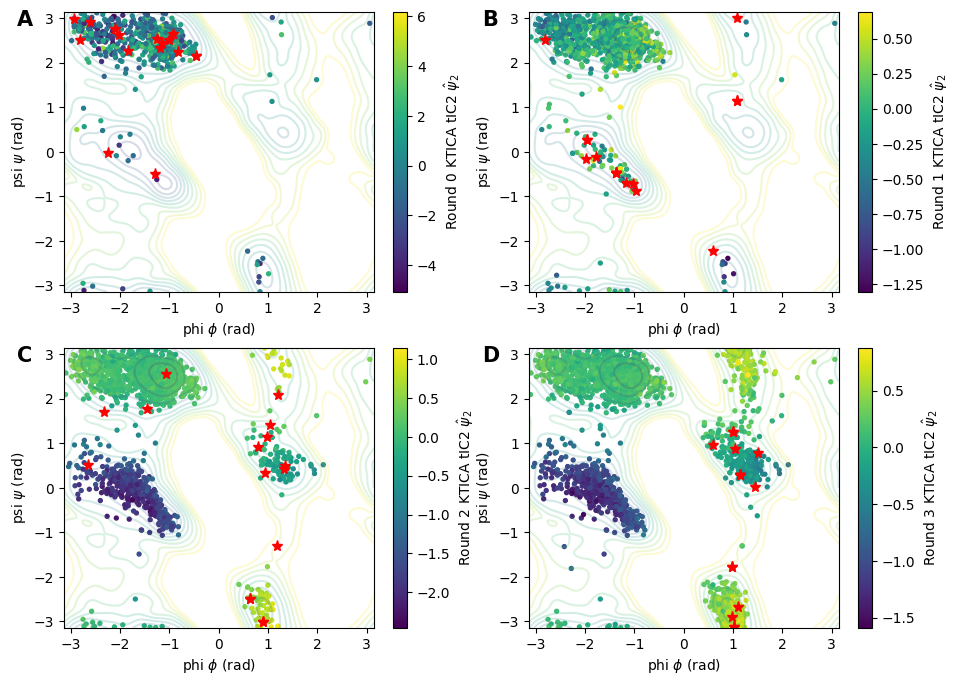

In [11]:
# Adaptive sampling seed selection
index_x = -0.15
index_y = 0.95

fig,ax = plt.subplots(nrows=2,ncols=2,sharex=False,sharey=False,figsize=(11,8))

# We want to include FES as contour plots in the background

vmax = 25

levels = np.linspace(0,vmax,11)
cv1 = 'phi'
cv2 = 'psi'
fes_2d = plumed.read_as_pandas('opes/COLVAR/hist-fes1/fes2d-{cv1}-{cv2}.dat'.format(cv1=cv1,cv2=cv2))
nbins = int(np.sqrt(len(fes_2d.iloc[:,2])))
x = np.linspace(fes_2d[cv1].min(), fes_2d[cv1].max(), nbins)
y = np.linspace(fes_2d[cv2].min(), fes_2d[cv2].max(), nbins)
X, Y = np.meshgrid(x, y)
Z = fes_2d.iloc[:,2].to_numpy().reshape(nbins,nbins).T

ax[0,0].contour(X, Y, Z,vmax=vmax,color='black',levels=levels,alpha=0.2)
ax[0,1].contour(X, Y, Z,vmax=vmax,color='black',levels=levels,alpha=0.2)
ax[1,0].contour(X, Y, Z,vmax=vmax,color='black',levels=levels,alpha=0.2)
ax[1,1].contour(X, Y, Z,vmax=vmax,color='black',levels=levels,alpha=0.2)

# Plot data points with tica values as color
# Plot seeding points

traj_length = 41

idx = 1
sc1 = ax[0,0].scatter(ref_data['phi'][:(n_sim*traj_length*idx)],ref_data['psi'][:(n_sim*traj_length*idx)],c=tica_round_all[idx-1][:(n_sim*traj_length*idx),1],s=8)
for i,j in round_seed_all[idx-1]:
    ax[0,0].plot(ref_df[i]['phi'][j],ref_df[i]['psi'][j],'*',ms=8,color='red')
plt.colorbar(sc1,ax=ax[0,0],label=r'Round 0 KTICA tIC2 $\hat \psi_2$')
    
idx = 2
sc2 = ax[0,1].scatter(ref_data['phi'][:(n_sim*traj_length*idx)],ref_data['psi'][:(n_sim*traj_length*idx)],c=tica_round_all[idx-1][:(n_sim*traj_length*idx),1],s=8)
for i,j in round_seed_all[idx-1]:
    ax[0,1].plot(ref_df[i]['phi'][j],ref_df[i]['psi'][j],'*',ms=8,color='red')
plt.colorbar(sc2,ax=ax[0,1],label=r'Round 1 KTICA tIC2 $\hat \psi_2$')

idx = 3
sc3 = ax[1,0].scatter(ref_data['phi'][:(n_sim*traj_length*idx)],ref_data['psi'][:(n_sim*traj_length*idx)],c=tica_round_all[idx-1][:(n_sim*traj_length*idx),1],s=8)
for i,j in round_seed_all[idx-1]:
    ax[1,0].plot(ref_df[i]['phi'][j],ref_df[i]['psi'][j],'*',ms=8,color='red')
plt.colorbar(sc3,ax=ax[1,0],label=r'Round 2 KTICA tIC2 $\hat \psi_2$')

idx = 4
sc4 = ax[1,1].scatter(ref_data['phi'][:(n_sim*traj_length*idx)],ref_data['psi'][:(n_sim*traj_length*idx)],c=tica_round_all[idx-1][:(n_sim*traj_length*idx),1],s=8)
for i,j in round_seed_all[idx-1]:
    ax[1,1].plot(ref_df[i]['phi'][j],ref_df[i]['psi'][j],'*',ms=8,color='red')
plt.colorbar(sc4,ax=ax[1,1],label=r'Round 3 KTICA tIC2 $\hat \psi_2$')

ax[0,0].text(index_x, index_y, string.ascii_uppercase[0],transform=ax[0,0].transAxes, size=15, weight='bold')
ax[0,0].set_xlabel('phi $\phi$ (rad)')
ax[0,0].set_ylabel('psi $\psi$ (rad)')
ax[0,1].text(index_x, index_y, string.ascii_uppercase[1],transform=ax[0,1].transAxes, size=15, weight='bold')
ax[0,1].set_xlabel('phi $\phi$ (rad)')
ax[0,1].set_ylabel('psi $\psi$ (rad)')
ax[1,0].text(index_x, index_y, string.ascii_uppercase[2],transform=ax[1,0].transAxes, size=15, weight='bold')
ax[1,0].set_xlabel('phi $\phi$ (rad)')
ax[1,0].set_ylabel('psi $\psi$ (rad)')
ax[1,1].text(index_x, index_y, string.ascii_uppercase[3],transform=ax[1,1].transAxes, size=15, weight='bold')
ax[1,1].set_xlabel('phi $\phi$ (rad)')
ax[1,1].set_ylabel('psi $\psi$ (rad)')

#plt.tight_layout()
plt.setp(ax,xlim=(-3.142,3.142),ylim=(-3.142,3.142))

plt.savefig('figures/adaptive_seeding_tIC2.png',dpi=600,bbox_inches='tight')
plt.show()

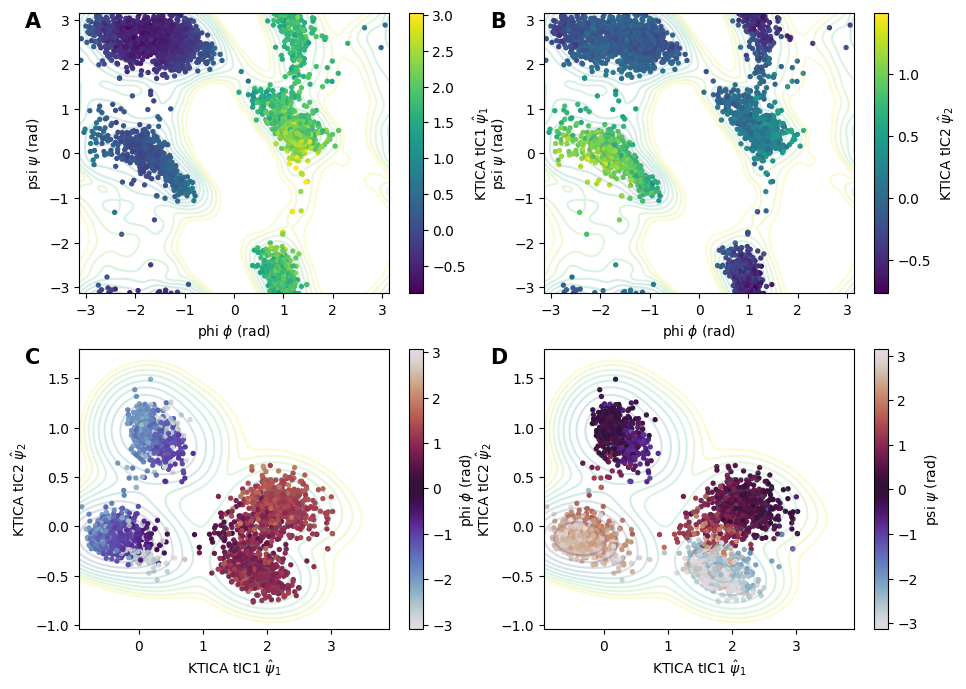

In [12]:
index_x = -0.175
index_y = 0.95

fig,ax = plt.subplots(nrows=2,ncols=2,sharex=False,sharey=False,figsize=(11,8))

# We want to include FES as contour plots in the background

vmax = 25

levels = np.linspace(0,vmax,11)
cv1 = 'phi'
cv2 = 'psi'
fes_2d = plumed.read_as_pandas('opes/COLVAR/hist-fes1/fes2d-{cv1}-{cv2}.dat'.format(cv1=cv1,cv2=cv2))
nbins = int(np.sqrt(len(fes_2d.iloc[:,2])))
x = np.linspace(fes_2d[cv1].min(), fes_2d[cv1].max(), nbins)
y = np.linspace(fes_2d[cv2].min(), fes_2d[cv2].max(), nbins)
X, Y = np.meshgrid(x, y)
Z = fes_2d.iloc[:,2].to_numpy().reshape(nbins,nbins).T

ax[0,0].contour(X, Y, Z,vmax=vmax,color='black',levels=levels,alpha=0.2)
ax[0,1].contour(X, Y, Z,vmax=vmax,color='black',levels=levels,alpha=0.2)

cv1 = 'tica0'
cv2 = 'tica1'
fes_2d = plumed.read_as_pandas('opes/COLVAR/hist-fes0/fes2d-{cv1}-{cv2}.dat'.format(cv1=cv1,cv2=cv2))
nbins = int(np.sqrt(len(fes_2d.iloc[:,2])))
x = np.linspace(fes_2d[cv1].min(), fes_2d[cv1].max(), nbins)
y = np.linspace(fes_2d[cv2].min(), fes_2d[cv2].max(), nbins)
X, Y = np.meshgrid(x, y)
Z = fes_2d.iloc[:,2].to_numpy().reshape(nbins,nbins).T

ax[1,0].contour(X, Y, Z,vmax=vmax,color='black',levels=levels,alpha=0.2)
ax[1,1].contour(X, Y, Z,vmax=vmax,color='black',levels=levels,alpha=0.2)

sc1 = ax[0,0].scatter(ref_data['phi'],ref_data['psi'],c=tica_output_concat[:,0],s=8)
sc2 = ax[0,1].scatter(ref_data['phi'],ref_data['psi'],c=tica_output_concat[:,1],s=8)
sc3 = ax[1,0].scatter(tica_output_concat[:,0],tica_output_concat[:,1],c=ref_data['phi'],s=8,cmap=matplotlib.colormaps['twilight'])
sc4 = ax[1,1].scatter(tica_output_concat[:,0],tica_output_concat[:,1],c=ref_data['psi'],s=8,cmap=matplotlib.colormaps['twilight'])

plt.colorbar(sc1,ax=ax[0,0],label=r'KTICA tIC1 $\hat \psi_1$')
plt.colorbar(sc2,ax=ax[0,1],label=r'KTICA tIC2 $\hat \psi_2$')
plt.colorbar(sc3,ax=ax[1,0],label='phi $\phi$ (rad)')
plt.colorbar(sc4,ax=ax[1,1],label='psi $\psi$ (rad)')

ax[0,0].text(index_x, index_y, string.ascii_uppercase[0],transform=ax[0,0].transAxes, size=15, weight='bold')
ax[0,0].set_xlabel('phi $\phi$ (rad)')
ax[0,0].set_ylabel('psi $\psi$ (rad)')
ax[0,1].text(index_x, index_y, string.ascii_uppercase[1],transform=ax[0,1].transAxes, size=15, weight='bold')
ax[0,1].set_xlabel('phi $\phi$ (rad)')
ax[0,1].set_ylabel('psi $\psi$ (rad)')
ax[1,0].text(index_x, index_y, string.ascii_uppercase[2],transform=ax[1,0].transAxes, size=15, weight='bold')
ax[1,0].set_xlabel(r'KTICA tIC1 $\hat \psi_1$')
ax[1,0].set_ylabel(r'KTICA tIC2 $\hat \psi_2$')
ax[1,1].text(index_x, index_y, string.ascii_uppercase[3],transform=ax[1,1].transAxes, size=15, weight='bold')
ax[1,1].set_xlabel(r'KTICA tIC1 $\hat \psi_1$')
ax[1,1].set_ylabel(r'KTICA tIC2 $\hat \psi_2$')

plt.savefig('figures/kTICA_CVs_vs_phi_psi',dpi=600,bbox_inches='tight')
plt.show()